# Feature Extraction

Convolutional networks used for image classification consist of two main components: a convolutional backbone, composed of convolution and pooling layers, followed by a classification head made up of fully-connected layers. Broadly speaking, the convolutional backbone extracts generic features from the input image, while the classification head interprets these features to make a prediction. Transfer learning takes advantage of this architecture to repurpose the convolutional backbone of a pre-trained network. Instead of training an entire model from scratch, the pre-trained backbone is reused to extract features from new data. Then, a new classifier is trained on top of these extracted features. 
This particular approach is commonly referred to as *feature extraction*.

In this tutorial, we will explain how to use feature extraction on the cats-vs-dogs dataset. We will download a pre-trained model from the TorchVision library, get the convolutional backbone from the model, and use it to extract features from images of cats and dogs. We will then train a new classifier on top of these features.

![feature extraction](pics/feature_extraction.png)

In [1]:
import torch, torchvision
import torch.nn.functional as F
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Preparation

First, we download a model that has been pre-trained on the ImageNet dataset. There are plenty of models to choose from in the TorchVision library. In this tutorial, we use [MobileNetV3](https://pytorch.org/vision/stable/models/mobilenetv3.html) for its speed and efficiency.

In [2]:
weights = MobileNet_V3_Large_Weights.DEFAULT
pretrained = mobilenet_v3_large(weights=weights)
preprocess = weights.transforms()

# Set to evaluation mode in feature extraction 
pretrained.eval();

Then, we load the cats-vs-dogs dataset and divide it into training and test sets. We assume that the data has been downloaded and extracted to the `.data/cats-vs-dogs/PetImages` directory. 

In [3]:
# TODO: Change this to the path where the dataset is stored
data_path = '.data/cats_vs_dogs/PetImages'

# Load the full dataset
dataset = torchvision.datasets.ImageFolder(data_path, transform=preprocess)

# Split the indices
train_idx, test_idx = train_test_split(range(len(dataset)), stratify=dataset.targets, test_size=0.2, shuffle=True, random_state=42)

# Create the subsets
train_ds = torch.utils.data.Subset(dataset, train_idx)
test_ds  = torch.utils.data.Subset(dataset, test_idx)

print(f'Train set: {len(train_ds):5d} images')
print(f'Test set:  {len(test_ds):5d} images')

Train set: 18728 images
Test set:   4682 images


```{note}
The tutorial [Dataset from files](../cnn/cnn-2.ipynb) explains how to download and prepare the cats-vs-dogs dataset.
```

## Analysis of MobileNetV3

Let's take a look at the architecture of MobileNetV3. By looping through the model's layers using the method `named_children`, we can see that the model consists of three modules. 
 - `features` - A series of convolutional and pooling layers to learn a representation of the input image.
 - `avgpool` - A layer that averages the channels of the input 3D tensor to produce a feature vector.
 - `classifier` - A series of fully-connected layers that predicts the class logits from the feature vector.


In [4]:
for name, module in pretrained.named_children():
    print(name)

features
avgpool
classifier


### Classification head

Let's visualize the classification head of MobileNetV3. We notice that the first layer expects a vector of size 960, while the last layer produces a vector of size 1000. 

In [5]:
print(pretrained.classifier)

Sequential(
  (0): Linear(in_features=960, out_features=1280, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1280, out_features=1000, bias=True)
)


We take note of the input size to the classification head because we will need this information to build a new classifier on top of the extracted features.

In [9]:
FLATTEN_DIM = pretrained.classifier[0].in_features

print("Flatten dimension:", FLATTEN_DIM)

Flatten dimension: 960


### Convolutional backbone

Let's visualize the convolutional backbone of MobileNetV3. We notice that the first layer expects a 3-channel image, while the last layer produces a 960-channel tensor. This information checks out with the input size of the classification head.

In [10]:
print(pretrained.features)

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (1): InvertedResidual(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
    )
  )
  (2): InvertedResidual(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine

To retrieve the exact size of the output tensor from the convolutional backbone, we need to pass a dummy input tensor through the model. We can then inspect the shape of the output tensor to determine the size of the extracted features.

In [12]:
with torch.inference_mode():
    image, _ = train_ds[0]
    batch = image.unsqueeze(0)
    features = pretrained.features(batch)

FEATURE_SHAPE = features.shape[1:]

print('Feature shape:', *FEATURE_SHAPE)

Feature shape: 960 7 7


## Standalone feature extractor

There are two ways to implement feature extraction: 

 - **Standalone approach**. Run the convolutional backbone over the whole dataset, store its output in a PyTorch Tensor, and then use this data as input to a standalone classifier. This solution is very fast and cheap to run, because it only requires running the pre-trained backbone once for every input image, which is by far the most expensive part of the pipeline. However, this technique would not allow us to leverage data augmentation at all.

 - **End-to-end approach**. Create a new model that combines the pre-trained backbone (with frozen weights) and a new classification head (with trainable weights). This allows us to use data augmentation, because every input image is going through the convolutional backbone every time it is seen by the model. However, fthis technique is far more expensive than the first one.
 
We will cover the standalone approach in this tutorial.

### Extracting features

Let's extract features from the cats-vs-dogs dataset by running the convolutional backbone over the whole dataset and store its output to a PyTorch Tensor. We will create a function `extract_features` that takes a model and a dataset as input, and returns a [`TensorDataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset) with the extracted features and the corresponding labels.

In [13]:
from torch.utils.data import Dataset, TensorDataset, DataLoader
from tqdm import tqdm

def extract_features(model: torch.nn.Module, 
                     dataset: Dataset, 
                     batch_size: int=64) -> TensorDataset:
    
    prev_device = next(model.parameters()).device
    device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu')
    
    model = model.to(device).eval()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    features = []
    labels = []
    
    for images, target in tqdm(dataloader, desc='Extracting features'):
        with torch.inference_mode():
            images = images.to(device)
            feats = model(images)
            features.append(feats.cpu())
            labels.append(target)

    features = torch.cat(features)
    labels = torch.cat(labels)

    model = model.to(prev_device)

    return TensorDataset(features, labels)

**WARNING**: The code below may take some time to run (around 15 minutes on CPU).

In [14]:
extracted_train_ds = extract_features(pretrained.features, train_ds)
extracted_test_ds  = extract_features(pretrained.features, test_ds)

Extracting features: 100%|██████████| 74/74 [00:41<00:00,  1.76it/s]


Let's print the size of the extracted features. We expect the size to be 960x7x7, as we saw earlier when analyzing the model.

In [15]:
print('Extracted features (shape):', *extracted_train_ds.tensors[0].shape)

Extracted features (shape): 18728 960 7 7


### Training a new classifier

Now that we have the extracted features, we can train a new classifier on top of them. We will use a simple feedforward neural network with two hidden layers. The input size of the network should match the size of the extracted features, while the output size should match the number of classes in the dataset.

In [16]:
class Classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        input_dim = 960 * 7 * 7
        self.fc = torch.nn.Linear(input_dim, 256)
        self.dropout = torch.nn.Dropout(0.5)
        self.out = torch.nn.Linear(256, 1)
    
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc(x))
        x = self.dropout(x)
        return self.out(x)

Let's import the training and evaluation functions from the [previous tutorials](../cnn/cnn-0.ipynb).

In [17]:
import sys
sys.path.append('../../code')  # folder with files: train.py, eval.py, metrics.py

from train import trainer
from eval import Evaluator
from metrics import binary_accuracy

Training is very fast, since we only have to deal with two fully-connected layers.

In [19]:
def loss_fn(output, target): 
    return F.binary_cross_entropy_with_logits(output.squeeze(), target.float())

classifier = Classifier()

loader = torch.utils.data.DataLoader(extracted_train_ds, batch_size=64, shuffle=True)
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001, amsgrad=True)

evaluator = Evaluator(extracted_test_ds, batch_size=128)
evaluator.add_metric("test", loss_fn)
evaluator.add_metric("accuracy", binary_accuracy)

history = trainer(classifier, loader, loss_fn, optimizer, epochs=5, evaluator=evaluator)

===== Training on mps device =====


Epoch  5/5: 100%|██████████| 293/293 [00:10<00:00, 27.27it/s, accuracy=0.988, test=0.0526, train_loss=0.00492]


Let's plot the loss of the model computed on the training and test sets. 

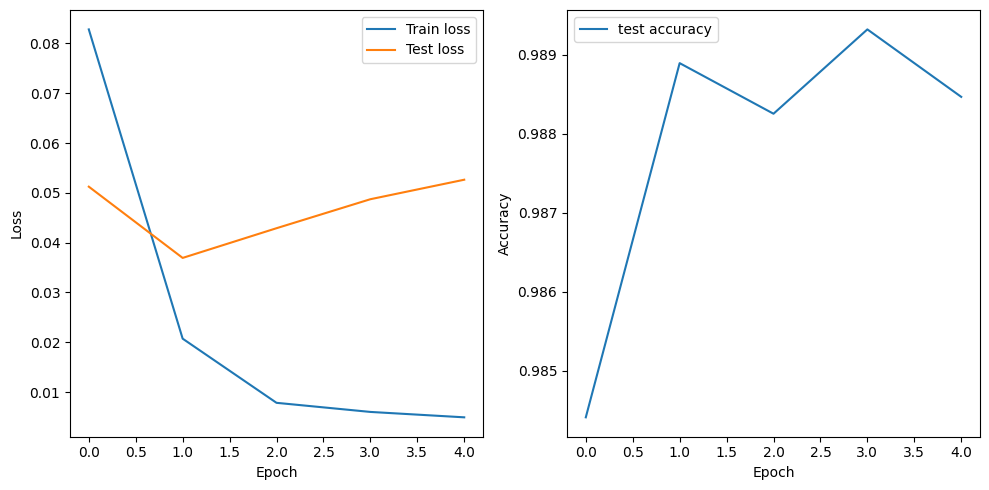

In [21]:
plt.figure(figsize=(10, 5), tight_layout=True)
plt.subplot(1, 2, 1)
plt.plot(history['train'], label='Train loss')
plt.plot(history['test'], label = 'Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The plots indicate that we are overfitting almost from the start, despite using dropout with a fairly large rate. Data augmentation may help to prevent overfitting in this case, but we need to use the end-to-end approach to leverage it (not covered in this tutorial).

### Evaluation

Finally, we evaluate the model on the test set and print the classification accuracy.

In [22]:
metrics = evaluator.evaluate(classifier)

print(f"Test accuracy: {metrics['accuracy']:.2%}")

Test accuracy: 98.85%


Let's also plot some images from the test set and their corresponding predictions.

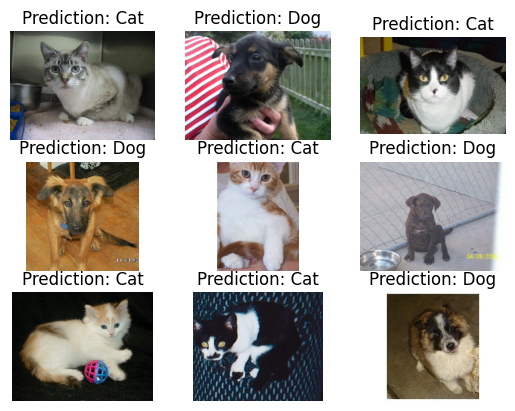

In [24]:
# Device of the classifier
device = next(classifier.parameters()).device

# Images without preprocessing
raw_data = torchvision.datasets.ImageFolder(data_path)

# Random image indices
n = 9
idx = torch.randint(0, len(raw_data), (n,))

# Retrieve original images
images, labels = zip(*[raw_data[i] for i in idx])

with torch.inference_mode():

    # Extract features
    batch = torch.stack([preprocess(img) for img in images])
    features = pretrained.features(batch)

    # Predict
    features = features.to(device)
    outputs = classifier(features)

# Plot
for i in range(n):
    plt.subplot(n//3, 3, i+1)
    plt.imshow(images[i])
    plt.title(f'Prediction: {"Dog" if outputs[i] > 0 else "Cat"}')
    plt.axis('off')
plt.show()

## Summary

In this tutorial, we learned how to use feature extraction to repurpose a pre-trained convolutional backbone for a new classification task. We downloaded a pre-trained MobileNetV3 from the TorchVision library, extracted features from the cats-vs-dogs dataset, and trained a new classifier on top of these features. The classifier achieved an impressive accuracy of 99% on the test set, which is not surprising given the simplicity of the dataset and its similarity to the ImageNet dataset.

Here are some key takeaways from this tutorial.

- **Why don't we reuse the pre-trained classification head?** The reason is that the representations learned by the classifier will necessarily be very specific to the set of classes that the model was trained on.

- **Should we always reuse the entire convolutional backbone?** The level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual edges, colors, and textures), while layers higher-up extract more abstract concepts (such as "cat ear" or "dog eye"). So if your new dataset differs a lot from the dataset that the original model was trained on, you may be better off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional backbone.